# import Library

In [1]:
import sys

sys.path.append('../')
from my_library.library import *
from hyperopt import hp, tpe, Trials, fmin,STATUS_OK
from my_library.funcs import *




# path ubu

In [ ]:
path_daw = '/home/hipro/デスクトップ/StockPriceData/Stock_index/DAW_10years.csv'
path_tpx = '/home/hipro/デスクトップ/StockPriceData/Stock_index/TOPIX_10years.csv'


# path mac

In [2]:
path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/rince/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/rince/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'
path_doll = '/Users/rince/Desktop/StockPriceData/Stock_index/doll_yen_bid.csv'


path_gold = '/Users/rince/Desktop/StockPriceData/Stock_index/gold_chusin.csv'
path_kawase = '/Users/rince/Desktop/StockPriceData/Stock_index/quote.csv'

# path win

In [ ]:
path_tpx = '/Users/Owner/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/Owner/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/Owner/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/Owner/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'

path_tpx_sim = '/Users/Owner/Desktop/StockPriceData/TOPIX/TOPIX_20211208.csv'
path_daw_sim = '/Users/Owner/Desktop/StockPriceData/DAW/DAW_20211208.csv'

# Learn XGB

---------------------
              precision    recall  f1-score   support

           0       0.48      0.44      0.46       248
           1       0.48      0.52      0.50       320
           2       0.51      0.51      0.51       246

    accuracy                           0.49       814
   macro avg       0.49      0.49      0.49       814
weighted avg       0.49      0.49      0.49       814



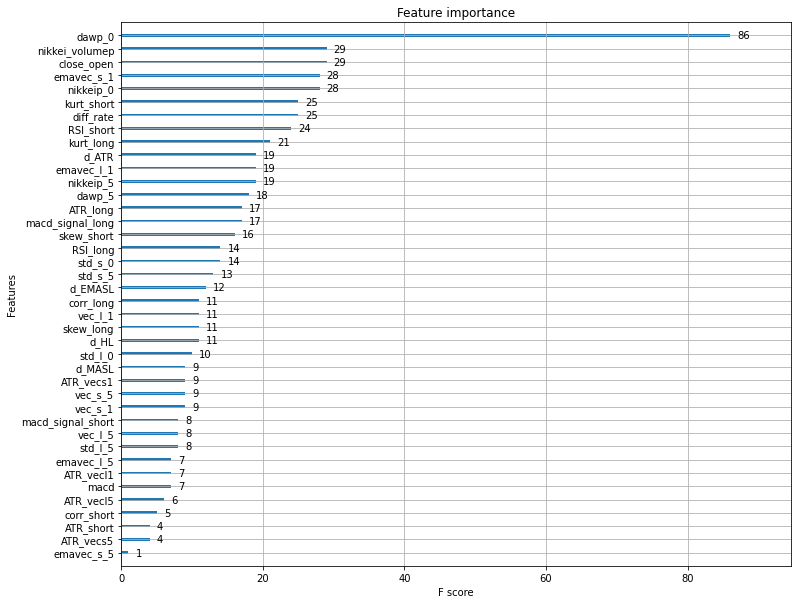

In [20]:
lx = LearnXGB(num_class=3)
lx.learn_xgb(path_tpx,path_daw)

# index 投信 

In [ ]:
tps = TPXSimulation()
tps.simulate(path_tpx,path_daw,start_year=2022,end_year=2022,start_month=1,end_month=12)
pr = tps.return_profit_rate()

# DAW simulte

In [ ]:
path_tpx_sim, path_daw_sim = return_latest_data_path('TOPIX')
ds = DawSimulation()
ds.simulate(path_tpx,path_daw,strategy='reverse',start_year=2021,end_year=2021,start_month=1,end_month=12)


# Random simulate

In [ ]:
path_tpx_sim, path_daw_sim = return_latest_data_path('TOPIX')
rs = RandomSimulation()
rs.simulate(path_tpx_sim,path_daw_sim,start_year=2022,end_year=2022,start_month=1,end_month=5)

# Technical simulate

In [ ]:
ts = TechnicalSimulation()
plt.grid()
ts.simulate(path_tpx,path_daw,start_year=2021,end_year=2021,start_month=1,end_month=12)
pr_log_ts = ts.pr_log

# predict tomorrow

In [ ]:
path_tpx_sim, path_daw_sim = return_latest_data_path('TOPIX')
lx.predict_tomorrow(path_tpx_sim,path_daw_sim,alpha=0.6,strategy='normal',start_year=2022,start_month=1,end_month=6,is_observed=True)

# フーリエ解析

# 各スペクトラムの代表ベクトル作成

#  Sim データリークしないように気をつけて

例) \
x[100] -> normal good \
実際にsim するのは z[120]あたり

# FFT Simulation new
is_abs = True

In [3]:
save_path = '/Users/rince/Desktop/Sotsuron/code/pickles/ffs_dict_good.pickle'
ffs_tmp = load_pickle(save_path)

In [4]:
save_path = '/Users/rince/Desktop/Sotsuron/code/pickles/Value_list.pickle'
Value_list =  load_pickle(save_path)

In [18]:
# is_abs = True

# param_dist =  { 
#             'n_estimators':16,
#             'max_depth':4,
#             'random_state':777
#             }
# # lx = LearnXGB(num_class=3)
# # lx.learn_xgb(path_tpx,path_daw,test_rate=0.7,param_dist=param_dist)

# lx = ffs_tmp.lx

# lc_dummy = LearnClustering()
# df_con = lc_dummy.make_df_con(path_tpx,path_daw)
# df_con = df_con[df_con.index.year<=2019]
# df_con = df_con[df_con.index.year>=2018]
# x_,z_ = lc_dummy.make_x_data(df_con['close'],stride=1,test_rate=1.0)

# length = len(z_)
# table_dict = {i : [] for i in range(lc_dummy.n_cluster)}
# Value_list = []
# alphas = [0.33]

# # n_cluster = 5
# log_dict = {}
# ffs_dict = {}

# alpha = 0.33
# # for n_cluster in [7,12,14,16]:
# for i in range(length):
#     for strategy in ['normal','reverse']:
#         try:
#             # alpha = 0.33
#             xl = XGBSimulation2(lx,alpha=alpha)
#             xl.simulate(path_tpx,path_daw,strategy=strategy,is_validate=True,start_year=2018,end_year=2019,df_=z_[i])
            
#             trade_log =  xl.trade_log
#             total_profit = trade_log['total_profit'].values[0]
#             stock_wave = z_[i]
#             vt = ValueTable(strategy,alpha,total_profit,trade_log,stock_wave)
#             Value_list.append(vt)
#         except:
#             continue

# ---------
Value_good = sorted(Value_list,key=lambda x :x[2],reverse=True)
Value_bad = sorted(Value_list,key=lambda x :x[2],reverse=False)
ng = []
rg = []
nb = []
rb = []

for v in Value_good:
    if v.total_profit<=0:break

    df = v.stock_wave
    strategy = v.strategy
    # print(df)
    # break
    if strategy=="normal":
        ng.append(standarize(df))
    else:
        rg.append(standarize(df))


for v in Value_bad:
    if v.total_profit>=0:break

    df = v.stock_wave
    strategy = v.strategy

    if strategy=="normal":
        nb.append(standarize(df))
    else:
        rb.append(standarize(df))

x_ng = make_easy_x(ng)
x_nb = make_easy_x(nb)
x_rg = make_easy_x(rg)
x_rb = make_easy_x(rb)




In [20]:
n_cluster=3
random_state=0
lc_rg = LearnClustering(n_cluster=n_cluster,random_state=random_state)
lc_rg.learn_clustering3(x_rg)
lc_rb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
lc_rb.learn_clustering3(x_rb)
lc_ng = LearnClustering(n_cluster=n_cluster,random_state=random_state)
lc_ng.learn_clustering3(x_ng)
lc_nb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
lc_nb.learn_clustering3(x_nb)

In [33]:
x_rb.shape

(182, 20)

--------------------
class : 0


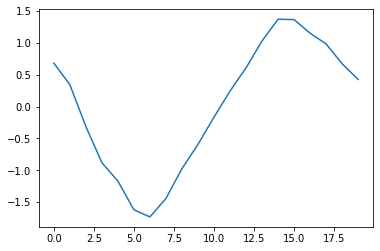

--------------------
class : 1


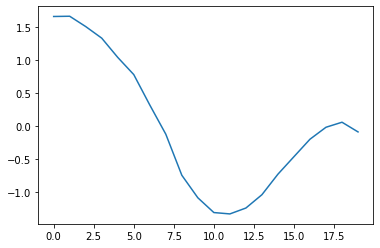

--------------------
class : 2


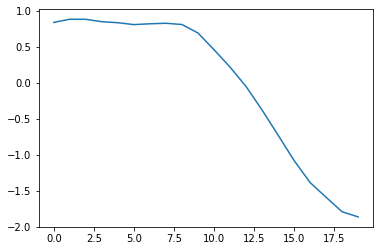

<Figure size 432x288 with 0 Axes>

In [42]:
lc_rb.show_class_wave()

In [59]:
print('{:.2f}'.format(1/2))

0.50


-------------


<Figure size 432x288 with 0 Axes>

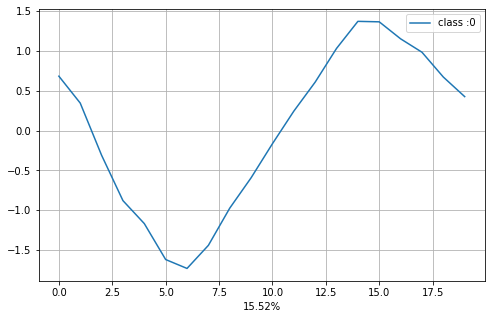

-------------


<Figure size 432x288 with 0 Axes>

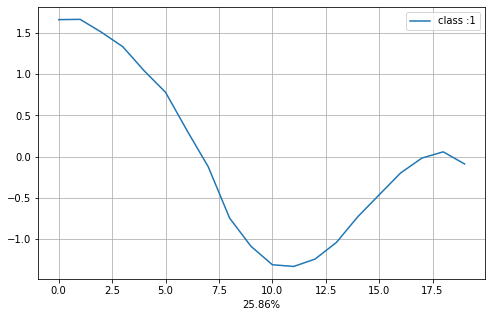

-------------


<Figure size 432x288 with 0 Axes>

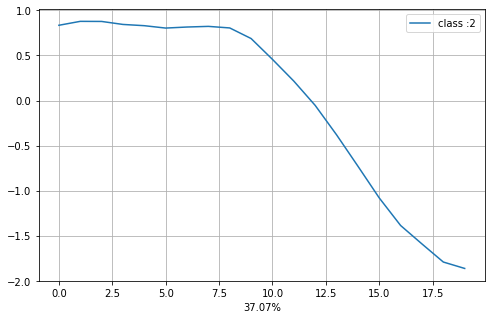

In [60]:
lis_ = lc_rb.model.labels_.tolist()
denom = sum(lis_)

for i in range(n_cluster):
    print("-------------")
    # print(lis_.count(i))
    plt.clf()
    _, ax = plt.subplots(figsize=(8, 5))
    plt.plot(lc_rb.wave_dict[i],label="class :"+str(i))
    plt.xlabel('{:.2f}'.format(lis_.count(i)*100/denom)+'%')
    plt.grid()
    plt.legend()
    plt.show()
    

In [39]:
lis_.count(0)

36

#  最適クラスタ数を調査

In [ ]:
is_abs=False
log_dict = {}
cs_dict = {}
ffs_dict = {}

# lx_ = LearnXGB(num_class=3)
# lx_.learn_xgb(path_tpx,path_daw,test_rate=0.8,param_dist=param_dist)
random_state=0

for n_cluster in range(1,21):
        
    Fstrategies = []
    Cstrategies = []
    lc_rg = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rg.learn_clustering3(x_rg)
    lc_rb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rb.learn_clustering3(x_rb)
    lc_ng = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_ng.learn_clustering3(x_ng)
    lc_nb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_nb.learn_clustering3(x_nb)

    strategy_list = ['normal','stay','reverse','stay']

    j=0
    for lc in [lc_ng,lc_nb,lc_rg,lc_rb]:
        
        for _,key in enumerate(lc.wave_dict):
            wave = lc.wave_dict[key]
            spe = make_spectrum(wave,is_abs=is_abs)
            strategy = strategy_list[j]
            fs  = Fstrategy(strategy,alpha,spe)
            cs = Fstrategy(strategy,alpha,wave)
            Fstrategies.append(fs)
            Cstrategies.append(cs)
        j+=1


    # cs_ = ClusterSimulation(lx_,Cstrategies)
    # cs_.simulate(path_tpx,path_daw,start_year=2019,end_year=2021,is_validate=True)
    ffs = FFTSimulation(ffs_tmp1[18].lx,Fstrategies,is_abs=is_abs)
    ffs.simulate(path_tpx,path_daw,start_year=2019,end_year=2021,is_validate=True)
    trade_log = ffs.trade_log
    # trade_log = cs_.trade_log
    log_dict[n_cluster] = trade_log
    # cs_dict[n_cluster] = cs_
    ffs_dict[n_cluster] = ffs

In [ ]:
for _, key in enumerate(log_dict):
    print("---------")
    print(key)
    trade_log = log_dict[key]
    print(trade_log)

In [ ]:
save_path= '/Users/rince/Desktop/Sotsuron/code/pickles/ffs_dict_good.pickle'
# save_pickle(save_path,ffs_)
ffs_good = load_pickle(save_path)

In [ ]:
# ffs_tmp1[1].is_abs=False
# ffs_ = ffs_dict[16]
for year in [2019,2020,2021]:
    ffs_good.simulate(path_tpx,path_daw,start_year=year,end_year=year,is_validate=False)
    # print(ffs_good.trade_log)


In [ ]:
xl = XGBSimulation2(ffs_tmp1[18].lx)
xl.simulate(path_tpx,path_daw,strategy='reverse',start_year=2019,end_year=2021)

In [1]:
save_path1= '/Users/rince/Desktop/Sotsuron/code/pickles/ffs_dict_579.pickle'
ffs_tmp1 = load_pickle(save_path1)
save_path2 = '/Users/rince/Desktop/Sotsuron/code/pickles/ffs_dict_debug.pickle'
ffs_tmp2 = load_pickle(save_path2)

NameError: name 'load_pickle' is not defined

In [16]:
def decode(spe):

    length = len(spe)
    mid = length//2

    real_ = spe[:mid]
    imag_ = spe[mid:]

    c_list = []
    for i in range(len(imag_)):
        c_list.append(complex(0,imag_[i]))

    c = np.array(c_list)
    F = real_ + c
    return F

# 業種別　解析

In [22]:

def get_gyosyu_df():
    path_gyosyu = '/Users/rince/Desktop/StockPriceData/Gyosyu/'
    FILE = glob.glob(path_gyosyu+'*.csv')
    df_dict = {}
    for file in FILE:
        name = file.replace(path_gyosyu,'')[:-4]
        df = pd.read_csv(file)
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:'open',\
                                    df.columns[6]:'high',df.columns[7]:'low',df.columns[8]:'close',\
                                        df.columns[9]:'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)
        df_dict[name] = df

    return df_dict,FILE


In [23]:
df_dict,FILE = get_gyosyu_df()

---------------------
              precision    recall  f1-score   support

           0       0.48      0.44      0.46       248
           1       0.48      0.52      0.50       320
           2       0.51      0.51      0.51       246

    accuracy                           0.49       814
   macro avg       0.49      0.49      0.49       814
weighted avg       0.49      0.49      0.49       814



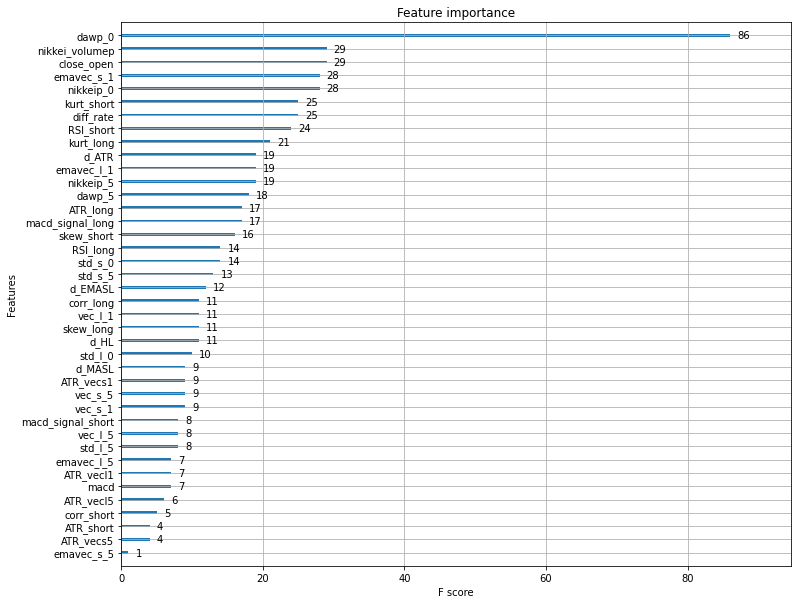

In [26]:
lx = LearnXGB(num_class=3)
lx.learn_xgb(path_tpx,path_daw)



In [28]:
len(FILE),len(df_dict)

(33, 33)

In [30]:
for i,key in enumerate(df_dict):
    xs = XGBSimulation2(lx)
    xs.simulate(FILE[i],path_daw,start_year=2019,is_validate=True)
    print("------------")
    print(key)
    print(xs.accuracy_df)

------------
SUISAN_NOURINGYO
      score  Up precision  Stay precision  Down precision  Up recall  \
0  0.441379      0.432526        0.361111        0.507812   0.545852   

   Stay recall  Down recall  up_num  stay_num  down_num  
0     0.290179     0.477941   229.0     224.0     272.0  
------------
JOUHOU_TSUUSIN
      score  Up precision  Stay precision  Down precision  Up recall  \
0  0.415172      0.458182        0.406593        0.376866   0.506024   

   Stay recall  Down recall  up_num  stay_num  down_num  
0     0.298387     0.442982   249.0     248.0     228.0  
------------
GINKOU
      score  Up precision  Stay precision  Down precision  Up recall  \
0  0.463448      0.439863        0.402174           0.536   0.587156   

   Stay recall  Down recall  up_num  stay_num  down_num  
0     0.308333     0.501873   218.0     240.0     267.0  
------------
KENSETSU
      score  Up precision  Stay precision  Down precision  Up recall  \
0  0.428966      0.459016        0.380952    